In [92]:
import proplot as pplt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import pandas as pd
import matplotlib
pplt.use_style('seaborn-talk')

def planck(wnum, temp):
    c1 = 1.1910427e-5 #mW/m2.sr.cm-1
    c2 = 1.4387752 #K/cm
    r = (c1 * np.power(wnum,3)) / ( np.exp( c2*wnum/temp) - 1.)
    return r
    
def rt(wnum, temp, opd, zenith_angle=0, sfc_t=None, sfc_e=None, upwelling=False, debug=False):
    opd = np.asarray(opd, dtype=np.float64) * (1./np.cos(np.radians(zenith_angle)))
    wnum = np.asarray(wnum, dtype=np.float64)
    temp = np.asarray(temp, dtype=np.float64)
    if upwelling is False:
        sfce = 0.
        k_start = len(opd)-1
        k_end = -1
        k_step = -1
    else:
        sfce = sfc_e
        if sfce < 0 or sfce > 1:
            print("Error: the surface emissivity is outside of [0,1]")
            sys.exit()        
        if sfc_t is None:
            # if no surface temperature is given, use the temperature of the lowest level
            sfct = temp[0]
        else:
            sfct = sfc_t
        sfc_b = planck(wnum, sfct)
        k_start = 0
        k_end = len(opd)
        k_step = 1

    rad = np.zeros(len(wnum))

    # use the linear in tau approach
    if sfce > 0:
        rad = sfc_b * sfce + rt(wnum, temp, opd) * (1.-sfce)
    # B_close is the Planck function for the temperature at the edge of the layer 
    # B_far | --> | B_close
    # 
    for k in np.arange(k_start, k_end, k_step):
        trans = np.asarray(np.exp(-1. * opd[k,:]), dtype=np.float64) # Compute the transmissivity of the layer
        if upwelling is True:
            # Compute the b_boundary from the bottom layer up
            b_close = planck(wnum, temp[k+1])
            layer_to_inst = np.exp(-1. * np.sum(opd[:k,:], axis=0))
        else:
            # Compute the b_boundary from the top of the layer down
            b_close = planck(wnum, temp[k])
            layer_to_inst = np.exp(-1. * np.sum(opd[k+1:,:], axis=0))
        b_avg = (planck(wnum, temp[k]) + planck(wnum, temp[k+1]))/2. # b_close and b_far
        b_eff = b_close + 2*(b_avg - b_close)*((1./opd[k,:]) - (trans/(1.-trans)))
        if debug == True:
            print("Temperature of top and bottom layer:", temp[k], temp[k+1])
            print("Planck top and bottom layer:", planck(wnum, temp[k]), planck(wnum, temp[k+1]))
            print("b_avg:", b_avg)
            print("Temperature of top and bottom layer:", temp[k], temp[k+1])
            print("b_close:", b_close) 
            print("b_avg:", b_avg)
            print("b_eff:", b_eff)
            print("Optical Depth of Current Layer:", opd[k,:])
            print("Terms of the RT for this layer:", (1-np.exp(-1.*opd[k,:])), b_avg, layer_to_inst)
            print("Calculation:", (1-np.exp(-1.*opd[k,:]))*b_eff*layer_to_inst) 
        rad = rad*trans + (1.-trans) * b_eff
    return rad

In [93]:
wnum = 800
temperatures = pd.Series([300,286,272,258,244,230], index=[0,2,4,6,8,10], name="Temperatures")
optical_depth = pd.Series([50.0,12.5,3.2,0.8,0.2], index=[1,3,5,7,9], name="Optical Depths")
optical_depth = pd.Series([0.500,.125,.032,0.008,0.002], index=[1,3,5,7,9], name="Optical Depths")

cloud_fraction = pd.Series([0,1,0,0,0], index=[1,3,5,7,9], name="Cloud Fraction")
cloud_optical_depth = pd.Series([0,4,0,0,0], index=[1,3,5,7,9], name="Cloud Optical Depth")

bb_rad = planck(wnum, temperatures).round(1)
sfc_t = 310
sfc_emissivity = 1
sfc_bb_rad = planck(wnum, sfc_t).round(1)

0
4
0
0
0


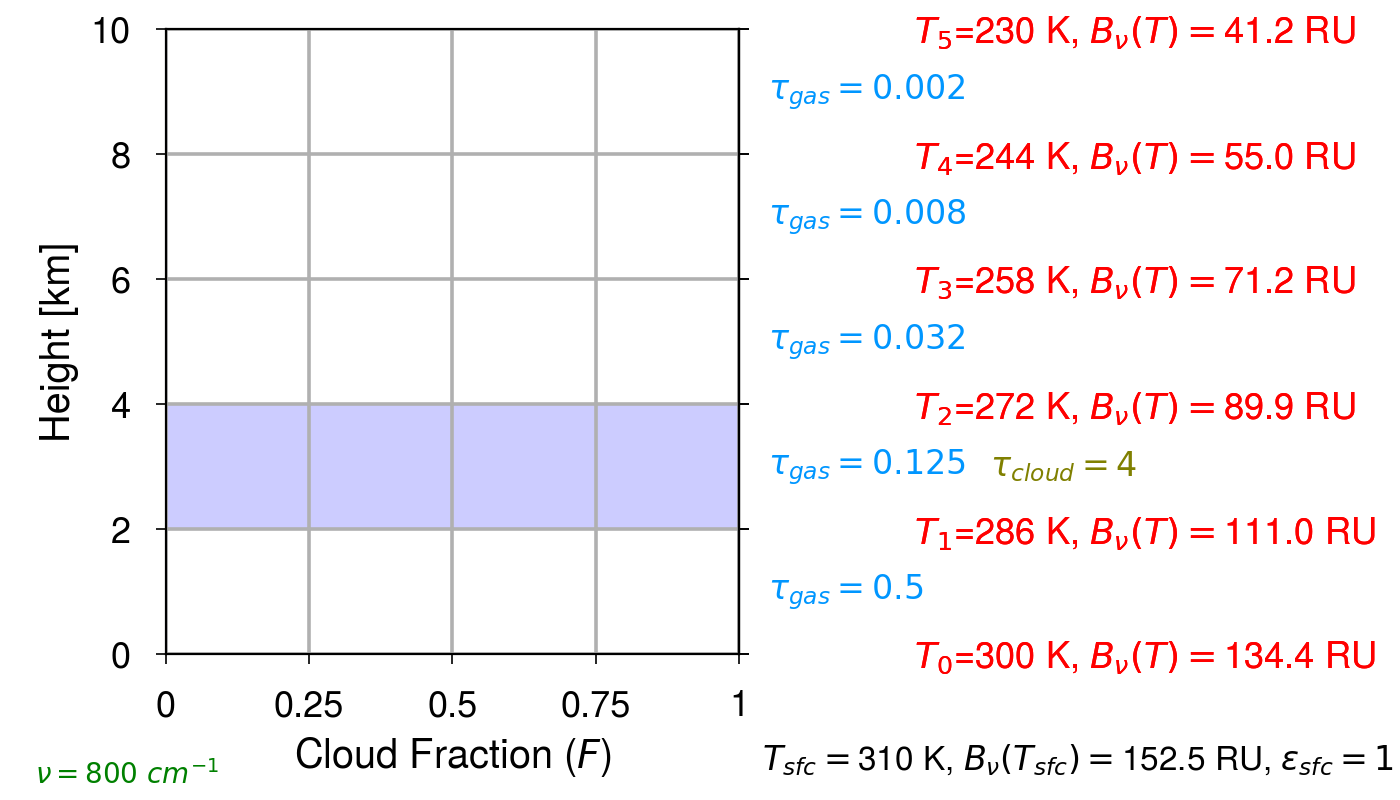

In [94]:
fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(7,4), sharex=False, sharey=False)
ax.format(ylim=(temperatures.index.min(), temperatures.index.max()), xlim=(0,1),
           ylabel="Height [km]", xticks=[0,0.25,0.5,0.75,1])

# Draw the temperatures and Planck function results at the layer boundaries.
ax.yaxis.set_ticks_position('both')
ax2 = ax.twinx()
thermo_ticks = []
for i, val in enumerate(zip(temperatures, bb_rad)):
    text = rf"              $T_{i}$={val[0]} K, $B_\nu(T)=${val[1]} RU"
    thermo_ticks.append(text)

ax2.format(yticks=np.asarray(temperatures.index), yticklabelcolor='red',
           ylim=(temperatures.index.min(), temperatures.index.max()), yticklabels=thermo_ticks)

ax.format(ylim=(temperatures.index.min(), temperatures.index.max()), xlim=(0,1),
           ylabel="Height [km]", xlabel="Cloud Fraction ($F$)")

for i, cf in cloud_fraction.items():
    ax.fill_between([0,cf], i-1, i+1, color='b', alpha=0.2)
    
#ax.yaxis.label.set_color('white')


ax.grid()

ax.text(0.77,0.05, rf"$T_{{sfc}}=${sfc_t} K, $B_\nu(T_{{sfc}})=${sfc_bb_rad} RU, $\epsilon_{{sfc}}={sfc_emissivity}$", 
        transform='figure', fontsize=12, horizontalalignment='center', verticalalignment='center')

trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

#ax.text(0.60,0.02, rf"$T_{{sfc}}=${sfc_t}, $B(T_{{sfc}})=${sfc_bb_rad} RU, $\epsilon={sfc_emissivity}$", transform='figure')
for i, val in optical_depth.items():
    ax.text(1.05,i, rf"$\tau_{{gas}}={val}$", transform=trans, color='#0096FF',
            fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')

for i, val in cloud_optical_depth.items():
    print(val)
    if val == 0:
        continue
    ax.text(1.05,i, rf"                        $\tau_{{cloud}}={val}$", transform=trans, color='#808000',
            fontweight='bold', fontsize=12, horizontalalignment='left', verticalalignment='center')


ax.text(0.025,.02, rf"$\nu={wnum}\ cm^{{-1}}$", transform='figure', color='green',
            fontweight='bold', fontsize=10)
"""
ax.format(urtitle='Downwelling')
plt.arrow(0.1, 9, dy=-9, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.3, 7, dy=-7, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.5, 5, dy=-5, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.7, 3, dy=-3, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.9, 1, dy=-1, dx=0, width=0.02, head_length=0.5, length_includes_head=True)

ax.format(lltitle='Upwelling')
plt.arrow(0.1, 9, dy=1, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.3, 7, dy=3, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.5, 5, dy=5, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.7, 3, dy=7, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
plt.arrow(0.9, 1, dy=9, dx=0, width=0.02, head_length=0.5, length_includes_head=True)
"""
fig.save('rte_problem_1a.pdf', bbox_inches='tight')

## Downwelling Radiance Calculation:

In [95]:
### Create LATEX CODE FOR THIS
optical_depth = optical_depth + cloud_optical_depth
# Downwelling
all_code = "I_\lambda^{\downarrow} = "
summed_rad = 0
for i in np.arange(len(optical_depth), 0, -1):
    #print(i)
    lyr_od = optical_depth.iloc[i-1]
    top_bb = bb_rad.iloc[i]
    bot_bb = bb_rad.iloc[i-1]
    eqstr = f"(1 - \exp [ \\textcolor{{optical_depth}}{{-{lyr_od}}} ] ) * & ( \\textcolor{{bb}}{{{top_bb} + {bot_bb}}} )/2"
    lyr2inst = optical_depth.iloc[:i-1]
    #if len(lyr2inst) > 1:
    if len(lyr2inst) >= 1:
        eqstr += " * \exp (-[ \\textcolor{optical_depth}{"
        for i, od_i in enumerate(lyr2inst):
            eqstr += f"{od_i}" 
            if i != len(lyr2inst) - 1:
                eqstr += " + "
        eqstr += "}]) + \\\\ \n"
    #print(eqstr)
    summed_rad += (1 - np.exp(-lyr_od)) * (top_bb + bot_bb)/2. * np.exp(-np.sum(lyr2inst))
    all_code += eqstr
all_code += f" = {summed_rad.round(1)}\ RU"
#print(all_code)
rad_linintau = rt([800], temperatures.to_numpy(), optical_depth.to_numpy()[:,np.newaxis])[0]

print(f"Downwelling Radiance: {summed_rad:.2f}")
print(f"Downwelling Radiance (linear-in-tau): {rad_linintau:.2f}")


Downwelling Radiance: 108.25
Downwelling Radiance (linear-in-tau): 112.06


## Upwelling Radiance Calculation:

In [96]:
### Create LATEX CODE FOR THIS
#Upwelling

all_code = r"I_\lambda^{\uparrow} = "
#summed_rad = 0

eqstr = f"{sfc_bb_rad} * {sfc_emissivity} * & \exp (-[ \\textcolor{{optical_depth}}{{"
lyr2inst = optical_depth[::-1]

summed_rad = sfc_bb_rad * sfc_emissivity * np.exp(-np.sum(lyr2inst))
for i, od_i in enumerate(lyr2inst):
    eqstr += f"{od_i}" 
    if i != len(lyr2inst) - 1:
        eqstr += " + "
eqstr += "}]) + \\\\ \n"
all_code += eqstr

for i in np.arange(len(optical_depth), 0, -1):
    #print(i)
    lyr_od = optical_depth[::-1].iloc[i-1]
    top_bb = bb_rad[::-1].iloc[i]
    bot_bb = bb_rad[::-1].iloc[i-1]
    eqstr = f"(1 - \exp [ \\textcolor{{optical_depth}}{{-{lyr_od}}} ] ) * & ( \\textcolor{{bb}}{{{top_bb} + {bot_bb}}} )/2"
    lyr2inst = optical_depth[::-1].iloc[:i-1]
    #if len(lyr2inst) > 1:
    if len(lyr2inst) >= 1:
        eqstr += " * \exp (-[ \\textcolor{optical_depth}{"
        for i, od_i in enumerate(lyr2inst):
            eqstr += f"{od_i}" 
            if i != len(lyr2inst) - 1:
                eqstr += " + "
        eqstr += "}]) + \\\\ \n"
    #print(eqstr)
    summed_rad += (1 - np.exp(-lyr_od)) * (top_bb + bot_bb)/2. * np.exp(-np.sum(lyr2inst))
    all_code += eqstr
all_code += f" = {summed_rad.round(1)}\ RU"
#print(all_code)

rad_linintau = rt([800], temperatures.to_numpy().squeeze(), optical_depth.to_numpy()[:,np.newaxis], sfc_t=sfc_t, sfc_e=sfc_emissivity, upwelling=True)[0]
print(f"Upwelling Radiance: {summed_rad:.2f}")
print(f"Upwelling Radiance (linear-in-tau): {rad_linintau:.2f}")

(6,)
(5,)
Upwelling Radiance: 100.05
Upwelling Radiance (linear-in-tau): 94.58
